## Reproductible forecasting

In [13]:
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import torch

import jmstate
from jmstate import (
    Fit,
    HazardFns,
    LogParamsHistory,
    ModelData,
    ModelDesign,
    ModelParams,
    MultiStateJointModel,
    ParamStop,
    SampleData,
    repr_from_cov,
)
from uniformbands import get_bands

In [2]:
torch.manual_seed(42)  # type: ignore


def sigmoid(t: torch.Tensor, psi: torch.Tensor):
    scale, offset, slope = psi.chunk(3, dim=-1)
    return (scale * torch.sigmoid((t - offset) / slope)).unsqueeze(-1)


def f(gamma: torch.Tensor | None, x: torch.Tensor | None, b: torch.Tensor):
    psi = cast(torch.Tensor, gamma) + b
    psi[..., 2].exp_()
    return psi


def random_far_apart(
    n: int, m: int, a: torch.Tensor, b: torch.Tensor, min_dist: torch.Tensor
):
    L_free = (b - a) - (m - 1) * min_dist

    y = torch.rand(n, m) * L_free
    y, _ = torch.sort(y, dim=1)

    gap_offset = torch.arange(m) * min_dist

    return a + y + gap_offset

In [3]:
lmda, k = 12.0, 2.0
weibull_fn = jmstate.functions.Weibull(k, lmda)

gamma = torch.tensor([3.7, 6.0, 1.2])

Q = torch.diag(torch.tensor([0.6, 1.9, 0.3]))
R = torch.tensor([[0.1]])

alphas = {("alive", "dead"): torch.tensor([0.4])}
betas = {("alive", "dead"): torch.tensor([-0.9, 0.8, 0.2])}

real_params = ModelParams(
    gamma,
    repr_from_cov(Q, method="diag"),
    repr_from_cov(R, method="ball"),
    alphas,
    betas,
)

Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)

In [4]:
model_design = ModelDesign(
    f, sigmoid, {("alive", "dead"): HazardFns(weibull_fn, sigmoid)}
)

In [5]:
real_model = MultiStateJointModel(model_design, real_params)

In [6]:
n, m, p = 500, 15, 3


def gen_data(n: int, m: int, p: int):
    c = torch.rand(n, 1) * 5 + 10
    x = torch.randn(n, p)

    b = Q_dist.sample((n,))
    psi = f(gamma, x, b)

    a = torch.zeros((n, 1))
    t = random_far_apart(n, m, a, c, 0.7 * c / m)

    trajectories_init = [[(0.0, "alive")] for _ in range(n)]
    sample_data = SampleData(x, trajectories_init, psi)
    trajectories = real_model.sample_trajectories(sample_data, c)

    y = model_design.regression_fn(t, psi).squeeze(0)
    y += R_dist.sample(y.shape[:2])

    return x, t, y, trajectories, c, psi

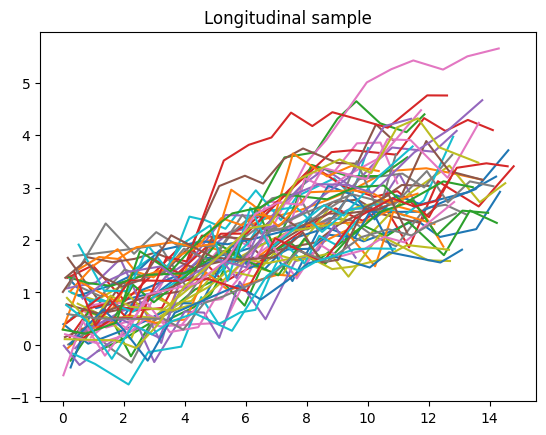

In [7]:
x, t, y, trajectories, c, _ = gen_data(n, m, p)

plt.plot(t[:50].T, y[:50].squeeze(-1).T)  # type: ignore
plt.title("Longitudinal sample")  # type: ignore
plt.show()  # type: ignore

In [8]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    repr_from_cov(torch.eye(Q.size(0)), method="diag"),
    repr_from_cov(torch.eye(R.size(0)), method="full"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = ModelData(x, t, y, trajectories, c)

In [9]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    job_factories=[
        Fit(lr=1.0, fused=True),
        LogParamsHistory(),
        ParamStop(),
    ],
    max_iterations=800,
)

Running joint model:  52%|█████▏    | 412/800 [00:12<00:11, 33.99it/s]


In [10]:
model.do(job_factories=jmstate.jobs.ComputeFIM())


Running joint model: 100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


namespace(params_history=[ModelParams(gamma=tensor([1.0000, 1.0000, 1.0000]), Q_repr=MatRepr(flat=tensor([-1.0000, -1.0000,  1.0000]), dim=3, method='diag'), R_repr=MatRepr(flat=tensor([1.0000]), dim=1, method='full'), alphas={('alive', 'dead'): tensor([1.0000])}, betas={('alive', 'dead'): tensor([-1.0000,  1.0000,  1.0000])}),
                          ModelParams(gamma=tensor([1.2388, 1.8365, 0.6197]), Q_repr=MatRepr(flat=tensor([-1.5692, -1.1267,  0.3243]), dim=3, method='diag'), R_repr=MatRepr(flat=tensor([0.4593]), dim=1, method='full'), alphas={('alive', 'dead'): tensor([0.3158])}, betas={('alive', 'dead'): tensor([-0.6673,  0.6478,  0.2635])}),
                          ModelParams(gamma=tensor([1.3624, 2.6040, 0.8674]), Q_repr=MatRepr(flat=tensor([-1.8625, -0.9074, -0.1376]), dim=3, method='diag'), R_repr=MatRepr(flat=tensor([0.2031]), dim=1, method='full'), alphas={('alive', 'dead'): tensor([-0.1944])}, betas={('alive', 'dead'): tensor([-0.5309,  0.4471, -0.3264])}),
         

In [11]:
n_test = 100

trajectories_init_test = [[(0.0, "alive")] for _ in range(n_test)]
x_test, t_test, y_test, trajectories_test, c_test, psi_test = gen_data(n_test, m, p)

Running joint model: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


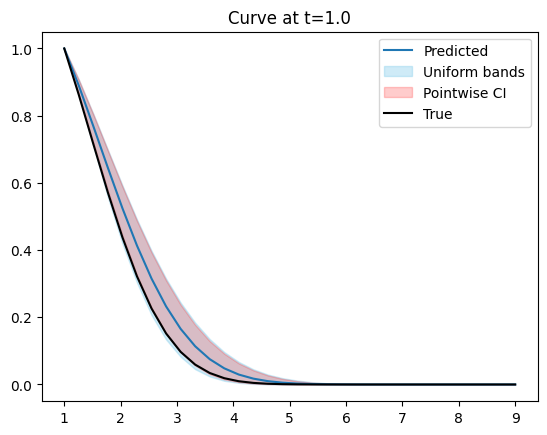

Running joint model: 100%|██████████| 100/100 [00:02<00:00, 34.93it/s]


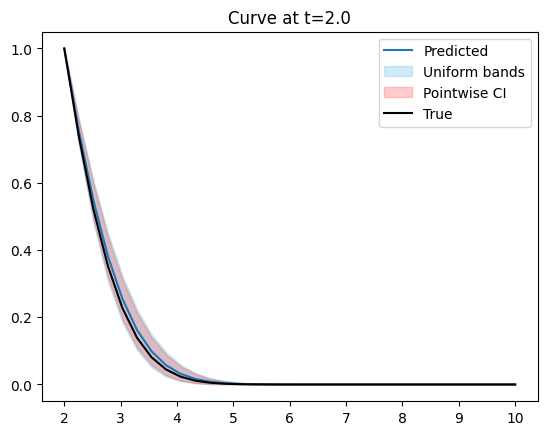

Running joint model: 100%|██████████| 100/100 [00:02<00:00, 40.75it/s]


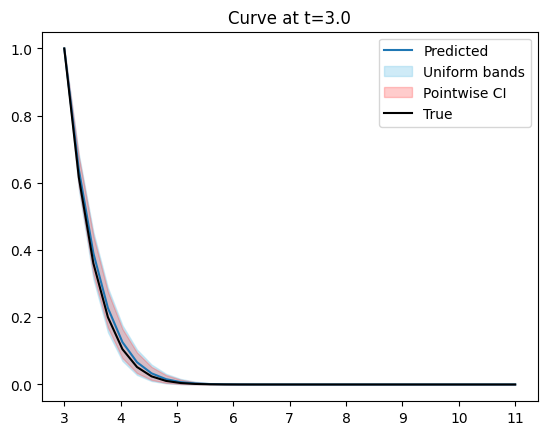

Running joint model: 100%|██████████| 100/100 [00:04<00:00, 21.53it/s]


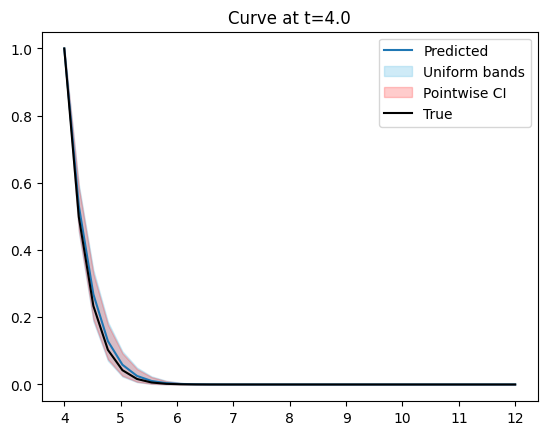

In [ ]:
prediction_times = torch.linspace(1.0, 4.0, 4)
u_grid = torch.linspace(0, 8, 32)


logps_true = []
for time in prediction_times:
    c_test = torch.full((n_test,), time).view(-1, 1)
    sample_test_data = SampleData(x_test, trajectories_init_test, psi_test, c_test)
    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_true.append(real_model.compute_surv_logps(sample_test_data, u))

uniform_coverage = []
pointwise_coverage = []

for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time).view(-1, 1)

    y_test_masked = y_test.clone()
    y_test_masked[t_test > time] = torch.nan
    pred_test_data = ModelData(
        x_test, t_test, y_test_masked, trajectories_init_test, c_test
    )

    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_pred = real_model.do(pred_test_data, job_factories=jmstate.jobs.PredictSurvLogps(u))
    logps_pred = torch.cat([d.unsqueeze(0) for d in logps_pred], dim=0)
    logps_pred = logps_pred.permute((1, 0, 2))

    uniform_covered_count = 0
    pointwise_covered_count = 0

    true_prob = torch.exp(logps_true[i]).numpy()
    pred_probs = torch.exp(logps_pred).numpy()

    bands = get_bands(pred_probs)
    pointwise = np.quantile(pred_probs, [0.025, 0.975], axis=1)

    uniform_covered_count += np.all(
        (true_prob >= bands["lower"]) & (true_prob <= bands["upper"]), axis=1
    ).mean()
    pointwise_covered_count += np.all(
        (true_prob >= pointwise[0]) & (true_prob <= pointwise[1]), axis=1
    ).mean()

    points = time + u_grid
    plt.plot(points, pred_probs[0].mean(axis=0), label="Predicted")
    plt.fill_between(
        points,
        bands["lower"][0],
        bands["upper"][0],
        color="skyblue",
        alpha=0.4,
        label="Uniform bands",
    )
    plt.fill_between(
        points,
        pointwise[0, 0],
        pointwise[1, 0],
        color="red",
        alpha=0.2,
        label="Pointwise CI",
    )
    plt.plot(points, true_prob[0], label="True", color="black")
    plt.title(f"Curve at t={time:.1f}")
    plt.legend()
    plt.show()

    uniform_coverage.append(uniform_covered_count)
    pointwise_coverage.append(pointwise_covered_count)

print(uniform_coverage)
print(pointwise_coverage)

Running joint model: 100%|██████████| 100/100 [00:01<00:00, 93.87it/s]


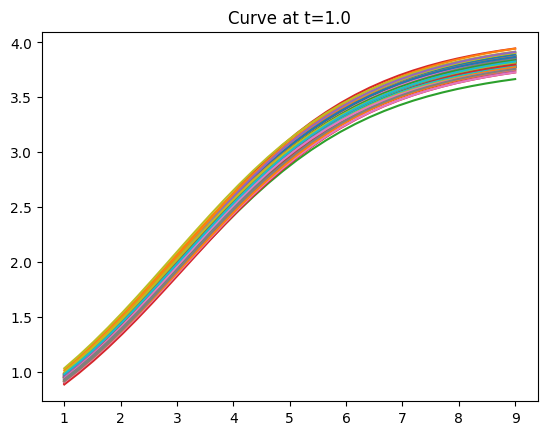

Running joint model: 100%|██████████| 100/100 [00:01<00:00, 89.26it/s]


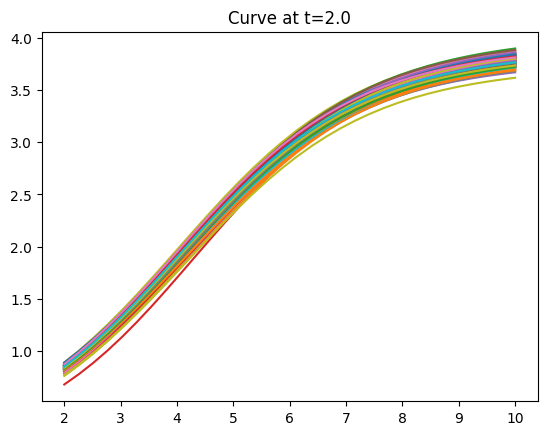

Running joint model: 100%|██████████| 100/100 [00:01<00:00, 50.75it/s]


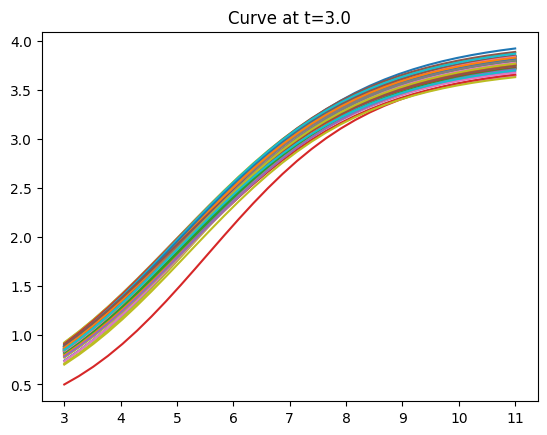

Running joint model: 100%|██████████| 100/100 [00:00<00:00, 173.94it/s]


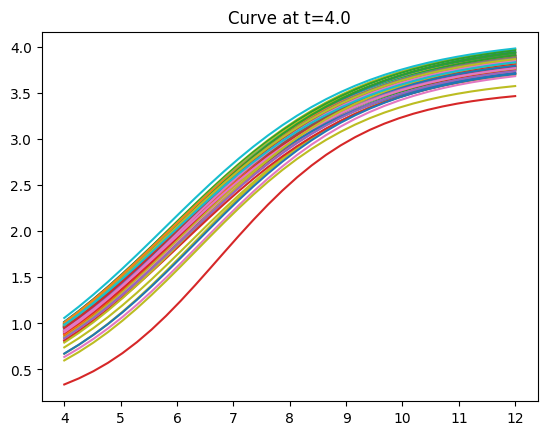

In [ ]:
for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time).view(-1, 1)

    pred_test_data = ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :], trajectories_init_test, c_test
    )
    y_pr = torch.cat(
        real_model.do(pred_test_data, jobs=jmstate.jobs.PredictY(u)), dim=2
    )
    points = time + u_grid
    plt.plot(points, y_pr.mean(dim=2).T)
    plt.title(f"Curve at t={time:.1f}")
    plt.show()